In [1]:
import math
import time
import tensorflow as tf
import numpy as np
import pylab as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

In [3]:
# Get current time
get_curr_millis = lambda: int(round(time.time() * 1000))

In [4]:
# Constants
NUM_FEATURES = 21
NUM_NEURONS = 10
NUM_CLASSES = 3

learning_rate = 0.01
weight_decay = 1e-6
epochs = 1
batch_sizes = [4, 8, 16, 32, 64]
num_folds = 5
seed = 10
np.random.seed(seed)

In [5]:
# Read from CSV
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')
trainX, train_Y = train_input[1:, :21], train_input[1:,-1].astype(int)
trainX = scale(trainX, np.min(trainX, axis=0), np.max(trainX, axis=0))

trainY = np.zeros((train_Y.shape[0], NUM_CLASSES))
trainY[np.arange(train_Y.shape[0]), train_Y-1] = 1 # one hot matrix

In [6]:
# Shuffle
print('Sample size: %d'%(trainX.shape[0]))
s = np.arange(trainX.shape[0]) # Create an index array
np.random.shuffle(s) # Shuffle the index array
trainX, trainY = trainX[s], trainY[s]

Sample size: 2126


In [7]:
# Split into 70:30 (train:test)
trainX, testX, trainY, testY = train_test_split(trainX, trainY, test_size=0.30, random_state=seed, shuffle=True)
print(trainX.shape)

(1488, 21)


In [8]:
# Create the model
x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

# Build the graph for the deep net
w1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, NUM_NEURONS], stddev=1.0/math.sqrt(float(NUM_FEATURES))), name='w1')
b1 = tf.Variable(tf.zeros([NUM_NEURONS]), name='b1')
hidden_relu = tf.nn.relu(tf.matmul(x, w1) + b1, name='relu')

w2 = tf.Variable(tf.truncated_normal([NUM_NEURONS, NUM_CLASSES], stddev=1.0/math.sqrt(float(NUM_NEURONS))), name='w2')
b2  = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
logits  = tf.matmul(hidden_relu, w2) + b2

# Apply Softmax activation function to output
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)

# Loss function with L2 Regularization with b = 10^-6
loss1 = tf.reduce_mean(cross_entropy)
regularizers = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2)
loss = tf.reduce_mean(loss1 + weight_decay * regularizers)

# Create the gradient descent optimizer with the given learning rate.
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [9]:
# Main
all_cv_acc = []
all_time = []

# Split dataset into number of folds
kf = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# For each batch size (4, 8 ,16, 32, 64)
for b in batch_sizes:
    print('================= Batch Size: %d =================' %b)
    batch_acc = []

    # For each fold (CV)
    for train_index, test_index in kf.split(trainX):
        fTrainX, fTestX = trainX[train_index], trainX[test_index]
        fTrainY, fTestY = trainY[train_index], trainY[test_index]
        
        exp_time = []

        # Run experiment
        with tf.Session() as sess:
            print('Experiment %d of %d: ' %(len(batch_acc)+1, num_folds))
            sess.run(tf.global_variables_initializer())

            exp_train_acc = []
            exp_test_acc = []

            start_time = get_curr_millis()
            # For each epoch
            for e in tqdm(range(epochs)):
                epoch_train_acc = []

                # Run mini-batch
                for start, end in zip(range(0, len(fTrainX), b), range(b, len(fTrainX), b)):
                    train_op.run(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]})
                    epoch_train_acc.append(accuracy.eval(feed_dict={x: fTrainX[start:end], y_: fTrainY[start:end]}))

                exp_train_acc.append(np.mean(np.array(epoch_train_acc)))
                exp_test_acc.append(accuracy.eval(feed_dict={x: fTestX, y_: fTestY}))

#                 if e % 100 == 0:
#                     print('Iter: %d' %e, ' | ', 'Train acc: %g' %exp_train_acc[e], ' | ', 'Test acc: %g' %exp_test_acc[e])

            end_time = get_curr_millis()
            exp_time.append(end_time-start_time)
            
            batch_acc.append(exp_test_acc)
        
    # After all experiments are completed, compute mean
    all_cv_acc.append(np.mean(np.array(batch_acc), axis=0))
    all_time.append(np.mean(np.array(exp_time)))
    print()

================= Batch Size: 4 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.25it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]



================= Batch Size: 8 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.56it/s]



================= Batch Size: 16 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.00it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.97it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.22it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.70it/s]



================= Batch Size: 32 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.96it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.90it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.31it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.43it/s]



================= Batch Size: 64 =================
Experiment 1 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.55it/s]


Experiment 2 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.40it/s]


Experiment 3 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.79it/s]


Experiment 4 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]


Experiment 5 of 5: 


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.13it/s]


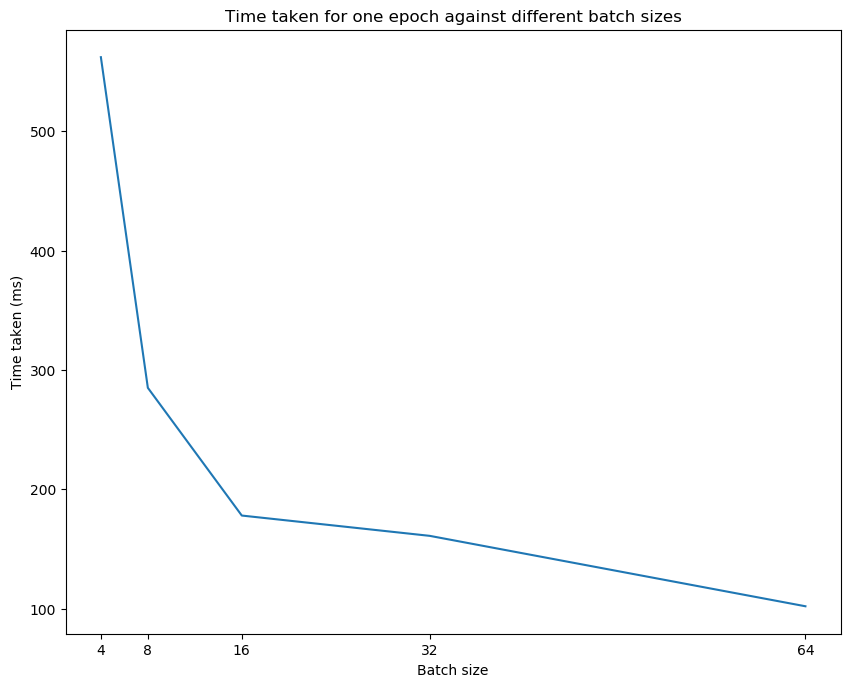

In [10]:
# Plot curves
plt.figure(1, figsize=(10, 8), dpi= 100)
plt.title('Time taken for one epoch against different batch sizes')

plt.plot(batch_sizes, all_time)
plt.xticks(batch_sizes)

plt.xlabel('Batch size')
plt.ylabel('Time taken (ms)')
# plt.legend()
plt.savefig('PartA_Qn2a_TimeTaken.png')
plt.show()